In [1]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 

In [2]:
data = pd.read_csv('/raid/tft-data/data/combined_news.csv')

In [3]:
#converting labels from strings to ints
data["label"].replace({"Real": 1, "Fake": 0}, inplace=True)

In [4]:
# Tokenizing Data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
max_seq_length = 512 

sequences = tokenizer.texts_to_sequences(data['text'])
padded = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

In [5]:
# Compartmentalizing data into training set and testing set
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

X = padded[:split_n]
y = data['label'].values[:split_n]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
# Other Model 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 64, input_length=512, trainable=False),
    tf.keras.layers.Conv1D(256, 5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(512, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(768, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_valid, y_valid))

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 64)           8833408   
_________________________________________________________________
conv1d (Conv1D)              (None, 512, 256)          82176     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 256, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 512)          131584    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 768)          393984    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 64, 768)           0

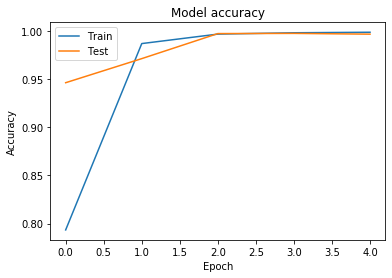

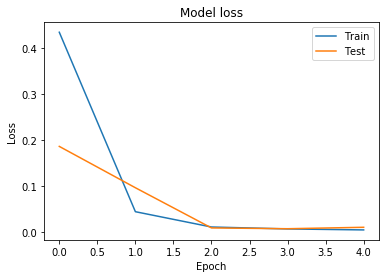

In [7]:
# Repeat for the Second Model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [8]:
y_pred = model.predict_classes(X_valid)
print('Confusion Matrix:')
print(confusion_matrix(y_valid, y_pred))
print('_________________________________________________')
print('Classification Report:')
print(classification_report(y_valid, y_pred, digits=4))
print('_________________________________________________')

# Testing the Results
print('Testing Results:')
y_pred_test = model.predict_classes(X_test)
print(classification_report(y_test, y_pred_test))

/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion Matrix:
[[3315   11]
 [   4 1699]]
_________________________________________________
Classification Report:
              precision    recall  f1-score   support

           0     0.9988    0.9967    0.9977      3326
           1     0.9936    0.9977    0.9956      1703

    accuracy                         0.9970      5029
   macro avg     0.9962    0.9972    0.9967      5029
weighted avg     0.9970    0.9970    0.9970      5029

_________________________________________________
Testing Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7036
           1       1.00      1.00      1.00      3740

    accuracy                           1.00     10776
   macro avg       1.00      1.00      1.00     10776
weighted avg       1.00      1.00      1.00     10776

